# 11wk-043: 아이스크림 판매량 / 배깅

최규빈  
2023-11-16

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xFzPZja1CacdZIpcYBNrfO&si=4I4-hymlHlQjTWuy>

# 2. Imports

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.tree
import sklearn.ensemble
#---#
import warnings
warnings.filterwarnings('ignore')
#---#
import matplotlib.animation
import IPython

# 3. Data + 의사결정나무로 적합

In [4]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:80]
temp.sort()
eps = np.random.randn(80)*3 # 오차
icecream_sales = 20 + temp * 2.5 + eps 
df_train = pd.DataFrame({'temp':temp,'sales':icecream_sales})
df_train

In [7]:
# step1 
X = df_train[['temp']]
y = df_train['sales']
# step2 
predictr = sklearn.tree.DecisionTreeRegressor()
# step3
predictr.fit(X,y)
# step4 -- pass

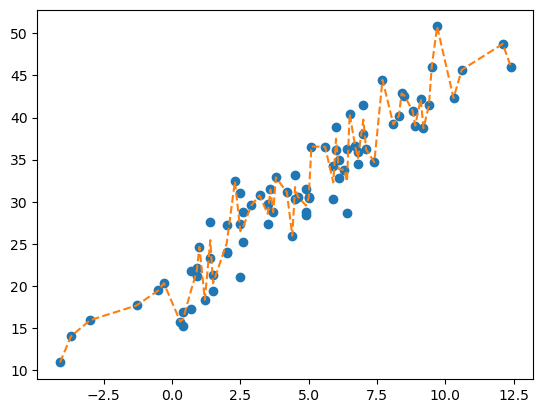

In [10]:
plt.plot(X,y,'o')
plt.plot(X,predictr.predict(X),'--')

# 4. 배깅으로 적합

In [275]:
# step1 
X = df_train[['temp']]
y = df_train['sales']
# step2 
predictr = sklearn.ensemble.BaggingRegressor()
# step3
predictr.fit(X,y)
# step4 -- pass

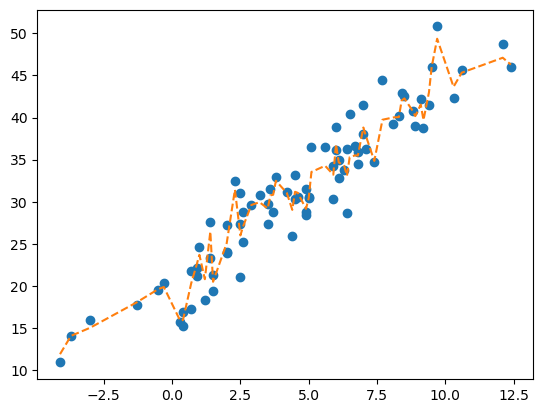

In [14]:
plt.plot(X,y,'o')
plt.plot(X,predictr.predict(X),'--')

# 5. 코드뜯어보기

## A. 원리

`-` 알고리즘

1.  80개의 샘플에서 80개를 중복을 허용하여 뽑는다.
2.  1에서 뽑힌 샘플들을 이용하여 tree를 적합시킨다.
3.  1-2를 10번 반복하고 10개의 tree의 평균값을 `yhat`으로 선택한다.

## B. `plot_tree` 체크

`-` 10개의 트리들의 리스트

In [30]:
trees = predictr.estimators_
trees

`-` 재표본데이터셋

In [39]:
predictr.estimators_samples_[0] # (X,y)의 쌍을 80개 중복을 허용하여 뽑기 위한 인덱스

In [41]:
samples = predictr.estimators_samples_

`-` 첫번째 트리 재현

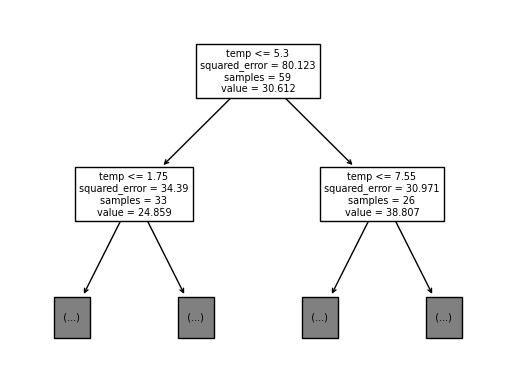

In [50]:
sklearn.tree.plot_tree(
    predictr.estimators_[0],
    feature_names=X.columns,
    max_depth=1
);

In [54]:
X_array = np.array(X)
y_array = np.array(y)

In [63]:
tree = sklearn.tree.DecisionTreeRegressor()
tree.fit(X_array[samples[0]],y_array[samples[0]])

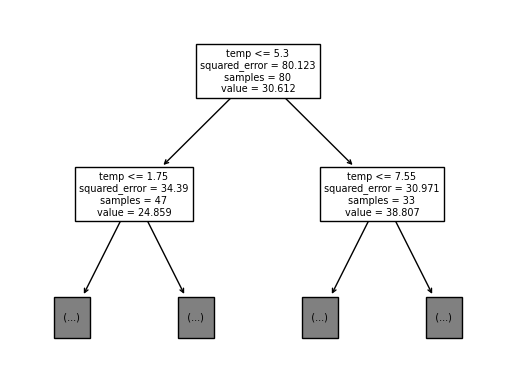

In [64]:
sklearn.tree.plot_tree(
    tree,
    feature_names=X.columns,
    max_depth=1
);

`-` tree 비교 (고정된 $i$)

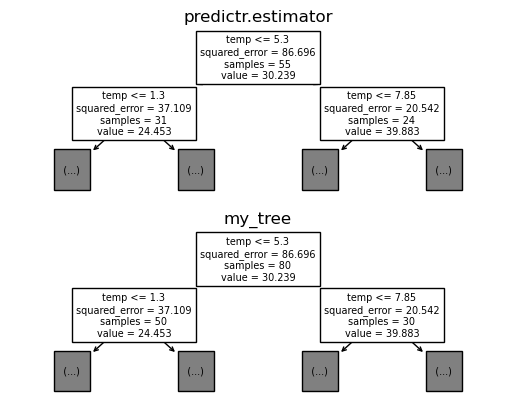

In [73]:
i=4
fig, ax = plt.subplots(2,1)
#---#
sklearn.tree.plot_tree(
    predictr.estimators_[i],
    feature_names=X.columns,
    max_depth=1,
    ax=ax[0]
)
ax[0].set_title('predictr.estimator')
#---#
my_tree = sklearn.tree.DecisionTreeRegressor()
my_tree.fit(X_array[samples[i]],y_array[samples[i]])
sklearn.tree.plot_tree(
    my_tree,
    feature_names=X.columns,
    max_depth=1,
    ax=ax[1]
);
ax[1].set_title('my_tree')

`-` tree 비교 (애니메이션)

In [77]:
fig, ax = plt.subplots(2,1)
plt.close()
#---#
def func(i):
    ax[0].clear()
    sklearn.tree.plot_tree(
        predictr.estimators_[i],
        feature_names=X.columns,
        max_depth=1,
        ax=ax[0]
    )
    ax[0].set_title('predictr.estimator')
    #---#
    ax[1].clear()
    my_tree = sklearn.tree.DecisionTreeRegressor()
    my_tree.fit(X_array[samples[i]],y_array[samples[i]])
    sklearn.tree.plot_tree(
        my_tree,
        feature_names=X.columns,
        max_depth=1,
        ax=ax[1]
    );
    ax[1].set_title('my_tree')
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=10)
display(IPython.display.HTML(ani.to_jshtml()))

## C. ReSampling + Fit

`-` 고정된 $i$

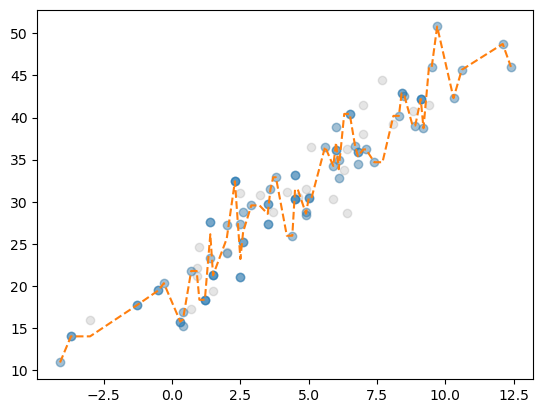

In [102]:
i=4
plt.plot(X,y,'o',alpha=0.2,color='gray')
plt.plot(X_array[samples[i]],y_array[samples[i]],'o',alpha=1/3)
plt.plot(X,trees[i].predict(X),'--')

`-` 애니매이션

In [109]:
#---#
fig = plt.figure()
ax = fig.gca() 
plt.close()
#---#
def func(i):
    ax.clear()
    ax.plot(X,y,'o',alpha=0.2,color='gray')
    ax.plot(X_array[samples[i]],y_array[samples[i]],'o',alpha=1/3)
    ax.plot(X,trees[i].predict(X),'--')
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=10)
display(IPython.display.HTML(ani.to_jshtml()))

## D. 앙상블결과 재현

`-` 최종결과물 (손으로..)

In [111]:
predictr.predict(X)

In [118]:
np.stack([tree.predict(X) for tree in predictr.estimators_]).mean(axis=0)

`-` 최종결과물 (코드로 정리)

In [235]:
def ensemble(trees,i=None):
    if i is None:
        i = len(trees)
    else: 
        i = i+1
    yhat = np.stack([tree.predict(X) for tree in trees[:i]]).mean(axis=0)
    return yhat

In [244]:
ensemble(trees,0) # 0번트리만 적용

In [245]:
ensemble(trees,1) # 0번트리,1번트리의 예측값 평균

## E. 학습과정 시각화

`-` 고정된 $i$

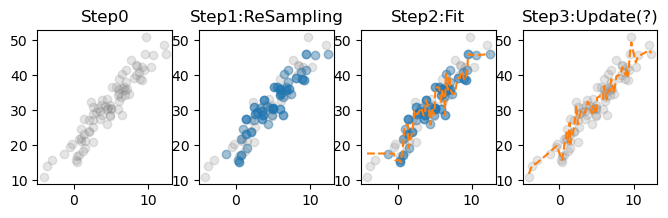

In [286]:
i=9
fig,ax = plt.subplots(1,4,figsize=(8,2))
#--#
ax[0].set_title("Step0")
ax[0].plot(X,y,'o',color='gray',alpha=0.2)
#--#
ax[1].set_title("Step1:ReSampling")
ax[1].plot(X,y,'o',color='gray',alpha=0.2)
ax[1].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
#--#
ax[2].set_title("Step2:Fit")
ax[2].plot(X,y,'o',color='gray',alpha=0.2)
ax[2].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
ax[2].plot(X,trees[i].predict(X),'--')
#--#
ax[3].set_title("Step3:Update(?)")
ax[3].plot(X,y,'o',color='gray',alpha=0.2)
ax[3].plot(X,ensemble(trees,i),'--',color='C1')

`-` 애니메이션

In [287]:
fig,ax = plt.subplots(1,4,figsize=(8,2))
plt.close()
#---#
def func(i):
    for a in ax:
        a.clear()
    #--#
    ax[0].set_title("Step0")
    ax[0].plot(X,y,'o',color='gray',alpha=0.2)
    #--#
    ax[1].set_title("Step1:ReSampling")
    ax[1].plot(X,y,'o',color='gray',alpha=0.2)
    ax[1].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
    #--#
    ax[2].set_title("Step2:Fit")
    ax[2].plot(X,y,'o',color='gray',alpha=0.2)
    ax[2].plot(X_array[samples[i]],y[samples[i]],'o',alpha=1/3)
    ax[2].plot(X,trees[i].predict(X),'--')
    #--#
    ax[3].set_title("Step3:Update(?)")
    ax[3].plot(X,y,'o',color='gray',alpha=0.2)
    ax[3].plot(X,ensemble(trees,i),'--',color='C1')
#---#
ani = matplotlib.animation.FuncAnimation(fig,func,frames=10)
display(IPython.display.HTML(ani.to_jshtml()))

# 6. Discussion

`-` 이런 방법을 생각한 근거? 부스트랩